In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

In [2]:
INPUT_PATH = 'D:/Datasets/green_in_glass/%03d%03d.png'

In [3]:
TOTAL_IMAGE_PER_CAMERA = 40
THESHOLD_RATIO = 0.10

In [4]:
def get_diff_mask(camerea_id,current_shot):
    previous_shot = (current_shot - 1) % TOTAL_IMAGE_PER_CAMERA
    # read image
    image_prev_uint = cv2.imread(INPUT_PATH % (camerea_id,previous_shot)) 
    image_current_uint = cv2.imread(INPUT_PATH % (camerea_id,current_shot)) 
    # convert to RGB
    image_prev_uint = cv2.cvtColor(image_prev_uint,cv2.COLOR_BGR2RGB)
    image_current_uint = cv2.cvtColor(image_current_uint,cv2.COLOR_BGR2RGB)
    # rotate
    image_prev_uint = cv2.rotate(image_prev_uint, cv2.ROTATE_90_CLOCKWISE)
    image_current_uint = cv2.rotate(image_current_uint, cv2.ROTATE_90_CLOCKWISE)
    # convert to [0-1]
    image_prev =  image_prev_uint / 255.0
    image_current = image_current_uint / 255.0
    # difference mask between 2 images
    diff_mask = np.linalg.norm(image_current - image_prev, axis=-1)
    diff_mask = (diff_mask > THESHOLD_RATIO) * 1.0
    #remove noise from sensor (hope this not ruin image)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    denoised_mask = cv2.morphologyEx(diff_mask, cv2.MORPH_OPEN, kernel)
    return denoised_mask

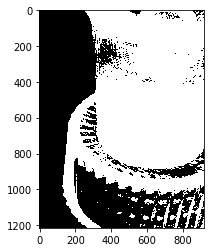

In [5]:
CAMERA_NUMBER = 7
foreground_prob = get_diff_mask(CAMERA_NUMBER,0)
for i in range(1,40):
    foreground_prob = cv2.bitwise_or(foreground_prob,get_diff_mask(CAMERA_NUMBER,i))
plt.imshow(foreground_prob,cmap='gray')

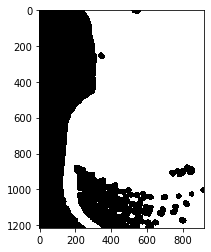

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
mask_closed = cv2.morphologyEx(foreground_prob, cv2.MORPH_CLOSE, kernel)
plt.imshow(mask_closed,cmap='gray')

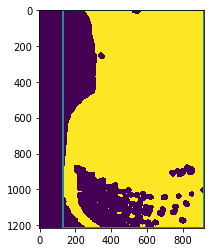

In [7]:
# find boundary (rectangle) of object 
mask_y, mask_x = np.nonzero(mask_closed)
min_x = np.min(mask_x)
max_x = np.max(mask_x)
min_y = np.min(mask_y)
max_y = np.max(mask_y)
mask_square = cv2.rectangle(mask_closed.copy(), (min_x,min_y), (max_x,max_y), (0.5), 10)
plt.imshow(mask_square)

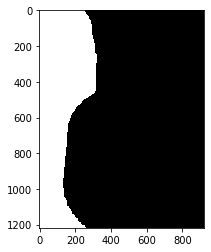

In [8]:
image_flooded = (mask_closed.copy() * 255.0).astype(np.uint8)
image_height, image_width = image_flooded.shape[:2]
flood_mask = np.zeros((image_height+2,image_width+2),dtype=np.uint8)
# top bar
if min_y != 0:
    for i in range(image_flooded.shape[1]):
        if image_flooded[0,i] != 255:
            cv2.floodFill(image_flooded, flood_mask, (0,i), 255)
# left bar
if min_x != 0:
    for i in range(image_flooded.shape[0]):
        if image_flooded[i,0] != 255:
            cv2.floodFill(image_flooded, flood_mask, (i,0), 255)

# right bar
most_right = image_flooded.shape[1] -1
if max_x != most_right:
    for i in range(image_flooded.shape[0]):
        if image_flooded[i,most_right] != 255:
            cv2.floodFill(image_flooded, flood_mask, (i,most_right), 255)

# bottom bar 
most_bottom = image_flooded.shape[0] -1
if max_y != most_bottom:
    for i in range(image_flooded.shape[1]):
        if image_flooded[most_bottom,i] != 255:
            cv2.floodFill(image_flooded, flood_mask, (most_bottom,i), 255)
plt.imshow(flood_mask,cmap='gray')

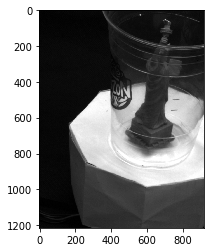

In [9]:
image_current_uint = cv2.imread(INPUT_PATH % (CAMERA_NUMBER,1)) 
image_current_uint = cv2.rotate(image_current_uint, cv2.ROTATE_90_CLOCKWISE)
image_gray = cv2.cvtColor(image_current_uint,cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray,cmap='gray')

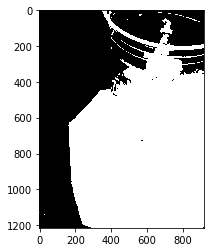

In [10]:
#ret2,th2 = cv2.threshold(image_gray,35,255,cv2.THRESH_BINARY)
ret2,object_threshold = cv2.threshold(image_gray,50,255,cv2.THRESH_TRIANGLE)
plt.imshow(object_threshold,cmap='gray')

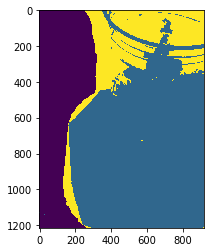

In [27]:
# create probability map
background_mask = flood_mask[1:-1,1:-1]
probability_map = np.zeros(image_gray.shape[:2])
probability_map[:,:] = cv2.GC_PR_FGD
probability_map[background_mask == 1] = cv2.GC_BGD
probability_map[object_threshold == 255] = cv2.GC_ FGD
plt.imshow(probability_map)

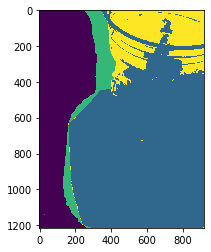

In [31]:
bgdmodel = np.zeros((1, 65), np.float64)
fgdmodel = np.zeros((1, 65), np.float64)
output = cv2.grabCut(image_current_uint.copy(), probability_map.astype(np.uint8), (0,0,0,0), bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_MASK)
plt.imshow(output[0])

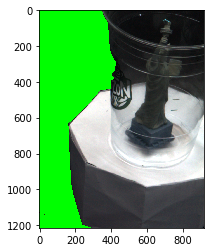

In [35]:
output_image = image_current_uint.copy()
output_image[output[0] == cv2.GC_BGD] = (0,255,0)
output_image[output[0] == cv2.GC_PR_BGD] = (0,255,0)
plt.imshow(output_image)